#### Lungs Cancer & AI in Healthcare
Lung cancer is one of the most deadly types of cancer in the world, mostly because it spreads quickly and is diagnosed too late.  Improving patient survival rates requires early diagnosis, but conventional techniques, such as manual CT scan analysis, can be laborious and prone to human error.  Artificial Intelligence (AI) has become a disruptive force in healthcare in recent years, especially in the field of medical imaging.  Artificial intelligence (AI)-powered solutions, particularly those built on deep learning, are able to swiftly and precisely evaluate vast amounts of scan data, spotting minute patterns that human eyes might overlook.  AI has the potential to improve early detection of lung cancer, shorten diagnostic wait times, and help physicians make more informed decisions more quickly, all of which would improve patient outcomes.

#### Problem Statement 
- Lung cancer remains a leading cause of cancer-related deaths globally, and while early detection significantly improves survival rates, traditional diagnostic methods like chest X-rays and basic CT scans are often inefficient, subjective, and prone to missing early-stage signs. The growing availability of imaging data and advancements in deep learning offer a promising solution for automating early lung cancer detection. However, current AI models face challenges such as difficulty distinguishing between benign and malignant nodules, high false-positive rates, poor generalizability, and lack of transparency, limiting clinical trust. This research proposes a robust deep learning framework using CNNs and attention mechanisms, combined with multi-scale feature extraction and explainable AI, to enhance detection accuracy and reliability while bridging the gap between AI innovations and real-world clinical application.


#### About Data Sets 
> Dataset is basically about the lung’s cancer CT image. It contains three categories of diagnostic lungs CT scan image such as benign cases, malignant cases and normal cases of lungs cancer. In other terms this dataset named as NIDC. The datasets contain total CT image of 1933 lungs which is clearly label according to the category, 467 benign cases, 1033 malignant cases and 416 normal cases of lungs cancer. The original image size is 512 * 512 and JPG in format. The NIDC dataset is recently publish in Mendeley websites in April 2025. Based on this dataset, still there is no paper is published in internet. This might be the first research regarding these datasets. The dataset is published by the radiology and imaging department NIDC Dhaka Bangladesh. 

#### Aims and Objective 
The primary proposed or aims of conducting research over this project topic is to build the better classification and detection system based on the advanced deep learning model that improves the early detection of lung cancer from CT scans image, history of patients by enhancing model accuracy, depreciating false positives, and providing interpretable predictions to assist clinical persons in decision-making and improving patient outcomes. Following bullets points represents the objective of the conducting research. 

 -	To collect and preprocess a comprehensive dataset of CT scans with annotated lung cancer cases. 
 -	To design and implement a deep learning model (e.g., CNN models) for feature extraction and classification. 
 -	To evaluate the model’s performance using appropriate metrics (accuracy, sensitivity, specificity, AUC, etc.). 
 -	To compare the proposed model with existing state-of-the-art methods. 
 -	To assess the model’s potential for integration into clinical workflows for early lung cancer screening. 


In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
#Sklearn -libraries 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
#To balance datasets 
from sklearn.utils import class_weight
#Open CV
import cv2
#Tensorflow and keras Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
import warnings
warnings.filterwarnings('ignore')

In [2]:
bengin_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Bengin cases'
malignant_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Malignant cases'
normal_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Normal cases'

# Categories 
img_classes = ["Bengin cases", "Malignant cases", "Normal cases"] 
path_list = [bengin_path, malignant_path, normal_path]

In [3]:
img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()


,img_path,label
0,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
1,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
2,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
3,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
4,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases


In [4]:
df.tail()

,img_path,label
1928,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...,Normal cases
1929,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...,Normal cases
1930,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...,Normal cases
1931,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...,Normal cases
1932,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...,Normal cases


In [5]:
df.info

<bound method DataFrame.info of                                                img_path         label
0     ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...  Bengin cases
1     ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...  Bengin cases
2     ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...  Bengin cases
3     ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...  Bengin cases
4     ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...  Bengin cases
...                                                 ...           ...
1928  ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...  Normal cases
1929  ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...  Normal cases
1930  ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...  Normal cases
1931  ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...  Normal cases
1932  ./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/No...  Normal cases

[1933 rows x 2 columns]>

In [6]:
df.shape

(1933, 2)

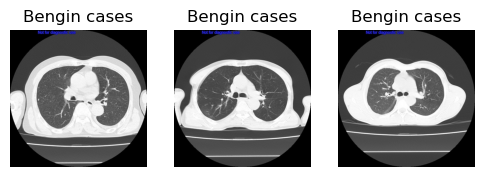

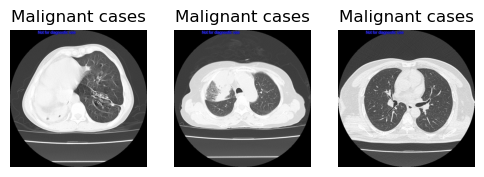

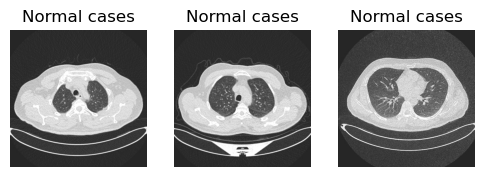

In [7]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (6,6))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

#### Exploratory Data Analysis 

In [8]:
countData = df["label"].value_counts().reset_index()
fig = px.histogram(data_frame = countData, x = "label", y = "count", width=600,
    height=400,
    title="Count of Labels by Category")
fig.show()

#### Analyzing the Image properties 

In [9]:
sizes = []
resolutions = []
color_distributions = []

for img_path in df ["img_path"]:
    # load image 
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #code to get image size
    size = os.path.getsize(img_path)
    sizes.append(size)
    #Extract the resolutions of images
    resolution = img.shape[:2]
    resolutions.append(resolution)
    #Extract color distribution
    mean_color_distributions = np.bincount(img.flatten(), minlength= 256)
    color_distributions.append(mean_color_distributions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)
print(color_distributions)

[[156807   2320   2160 ...   8145   9051  38040]
 [156929   2288   2080 ...   7888   8496  32148]
 [156853   2438   2068 ...   6837   8217  34251]
 ...
 [     0      0      0 ...    390    681  10509]
 [     0      0      0 ...    906   2463  34197]
 [     0      0      0 ...    975   2235  32346]]


#### Distributions Size of image

In [10]:
#Image sizes in MB
sizes_MB = []
for img_path in df["img_path"]:
    #code to load image
    img = cv2.imread(img_path)
    #code to get imge size 
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_000_000)

fig = px.histogram(x=sizes_MB, nbins = 50, title = "Distribution size of Image", width=600,
    height=400)
fig.update_layout(xaxis_title = "File Size (MB)",
                  yaxis_title = "Number of Images",
                  showlegend = False,
                  bargap = 0.1,
                  bargroupgap = 0.1)
fig.update_traces(marker = dict(color="green"))
fig.show()

#### Distributions of image Resulations 

In [11]:
fig = px.scatter(x = resolutions[:,0],
                 y = resolutions[:,1], 
                 title = "Distribution of Image Resolution", height= 400, width= 600)
fig.update_layout(
    xaxis_title = "Width (Pixel)",
    yaxis_title = "Height (Pixel)",
    showlegend = False,
    hovermode = "closest"
)
fig.update_traces(marker = dict(color="red"))
fig.show()

### Mean Color Distributins 

In [12]:
import plotly.graph_objects as go
mean_color_distributions = np.mean(color_distributions, axis = 0)
fig = go.Figure(
    go.Bar(x = np.arange(256), y = mean_color_distributions, name = "Mean Color Distributions"
))
fig.update_layout(
    title = "Mean Color Distribution",
    xaxis_title = "Color Values",
    yaxis_title = "Number of Pixel"
)
fig.show()

#### Train & test 

In [13]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio + val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

Train shape = (1353, 2)
Test shape = (290, 2)
Validation shape = (290, 2)


#### DeNoise image using median blur

In [14]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

#### Data Agrumendations using ImageDataGenerator


In [15]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                  rotation_range = 15,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest'
                                  )

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

#for training image 
train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    traget_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb', 
    class_mode = "categorical",
    shuffle = True
)


# for testing image 
test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    traget_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb', 
    class_mode = "categorical",
    shuffle = True
)

val_generator = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    traget_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb', 
    class_mode = "categorical",
    shuffle = True
)


Found 1353 validated image filenames belonging to 3 classes.
Found 290 validated image filenames belonging to 3 classes.
Found 290 validated image filenames belonging to 3 classes.


#### Class weight 

In [16]:

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)

# Convert to dictionary format
train_class_weights = dict(enumerate(class_weights))

classes = list(train_generator.class_indices.keys())
# Print class weights
for idx, weight in train_class_weights.items():
    class_name = classes[idx]  # Ensure 'classes' list is defined
    print(f"{class_name} : {weight:.2f}")  # Formatted to 2 decimal places

Bengin cases : 1.37
Malignant cases : 0.62
Normal cases : 1.53


#### Model  Implementations CNN Model 

In [17]:
model_2D = Sequential([
    # Conv Block 1
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(256,256, 3)),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 4
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 5
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 6
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(256, activation='relu'),
    Dropout(0.25),

    Dense(3, activation='softmax')  # Assuming 3 classes
]) 

model_2D.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,215,555 (4.64 MB)

 Trainable params: 1,213,763 (4.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [18]:
model_2D.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.0002),
    metrics = ["accuracy"],
)
epochs = 70
history = model_2D.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 250s 6s/step - accuracy: 0.5981 - loss: 0.6761 - val_accuracy: 0.2172 - val_loss: 2.0947 - learning_rate: 2.0000e-04
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - accuracy: 0.7742 - loss: 0.3746 - val_accuracy: 0.2172 - val_loss: 3.4911 - learning_rate: 2.0000e-04
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - accuracy: 0.7967 - loss: 0.3257 - val_accuracy: 0.2172 - val_loss: 5.9039 - learning_rate: 2.0000e-04
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 2812s 67s/step - accuracy: 0.8359 - loss: 0.2867 - val_accuracy: 0.2172 - val_loss: 10.7528 - learning_rate: 2.0000e-04
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 243s 6s/step - accuracy: 0.8486 - loss: 0.2550 - val_accuracy: 0.2172 - val_loss: 7.8082 - learning_rate: 2.0000e-04
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - accuracy: 0.8492 - loss: 0.2394 - val_accuracy: 0.2172 - val_loss: 7.0463 - learning_rate: 4.0000e-05


##### Training & validation Acuracy loss

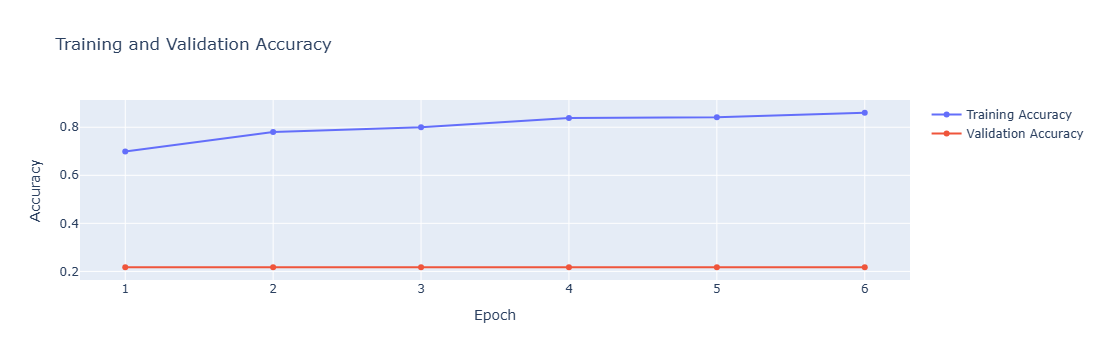

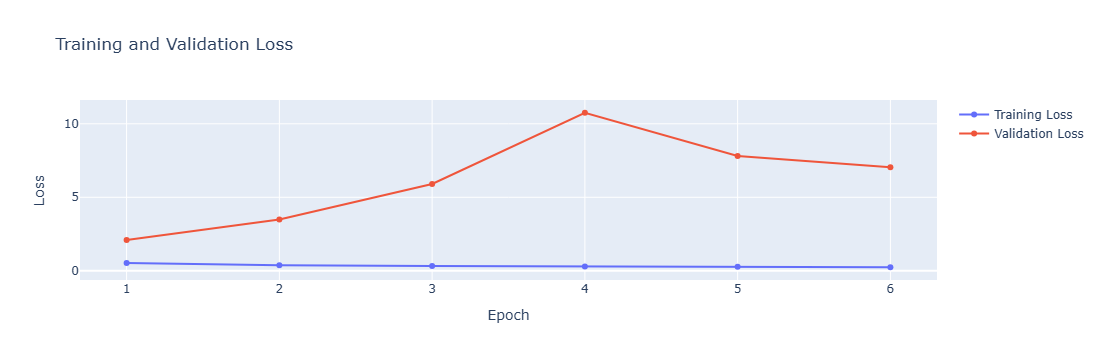

In [19]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["accuracy"], name = "Training Accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_accuracy"], name = "Validation Accuracy"))
    fig1.update_layout(title = "Training and Validation Accuracy", xaxis_title = "Epoch", yaxis_title = "Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["loss"], name = "Training Loss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_loss"], name = "Validation Loss"))
    fig2.update_layout(title = "Training and Validation Loss", xaxis_title = "Epoch", yaxis_title = "Loss")
    fig2.show()

history_plot(epochs, history)

In [20]:
def evaluate_model(model, test_generator):
    #Calculate test loss and accuracy
    results = model.evaluate(test_generator, verbose = 0)
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")
evaluate_model(model_2D, test_generator)

Test Loss = 2.112076759338379
Test Accuracy = 0.20344828069210052


In [21]:
# Get true labels and predicted probabilities
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predict class probabilities
y_pred_proba = model_2D.predict(test_generator, verbose=1)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)

# 1️⃣ Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 797ms/step
Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        76
Malignant cases       0.00      0.00      0.00       155
   Normal cases       0.20      1.00      0.34        59

       accuracy                           0.20       290
      macro avg       0.07      0.33      0.11       290
   weighted avg       0.04      0.20      0.07       290



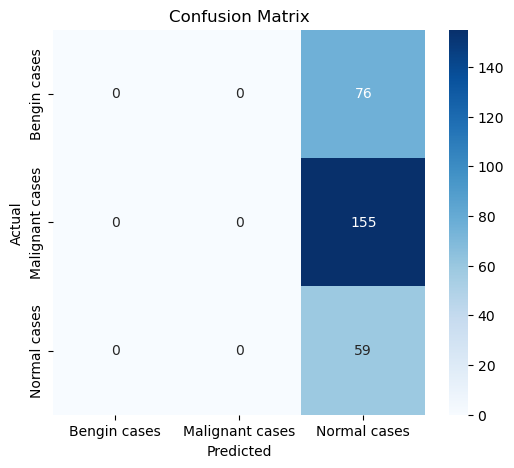

In [22]:
# 2️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### Transfer learning for improving Accuray (using Fine tune Model Vgg16 and InceptionsV3)

In [23]:
#Define base_model of InceptionV3
base_model = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")
#Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

#Add Custom layers
model_IV3 = Sequential()
model_IV3.add(Input(shape = (256, 256, 3)))
model_IV3.add(base_model)
model_IV3.add(GlobalAveragePooling2D())
model_IV3.add(Dense(1024, activation = "relu"))
model_IV3.add(Dropout(0.4))
model_IV3.add(Dense(3, activation = "softmax"))
#Compile and Training the model 
epochs = 70
model_IV3.compile(optimizer = Adam(0.0002),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])
history = model_IV3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.6072 - loss: 0.8205 - val_accuracy: 0.6586 - val_loss: 0.5992 - learning_rate: 2.0000e-04
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.7725 - loss: 0.4147 - val_accuracy: 0.6759 - val_loss: 0.6461 - learning_rate: 2.0000e-04
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7792 - loss: 0.4001 - val_accuracy: 0.7897 - val_loss: 0.4217 - learning_rate: 2.0000e-04
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - accuracy: 0.8155 - loss: 0.3333 - val_accuracy: 0.7207 - val_loss: 0.5564 - learning_rate: 2.0000e-04
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8052 - loss: 0.3643 - val_accuracy: 0.8586 - val_loss: 0.3065 - learning_rate: 2.0000e-04
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8162 - loss: 0.3396 - val_accuracy: 0.7345 - val_loss: 0.5344 - learning_rate: 2.0000e-04
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8078 

In [24]:
#Plot the graph
history_plot(epochs, history)

In [25]:
evaluate_model(model_IV3, test_generator)

Test Loss = 0.33428332209587097
Test Accuracy = 0.8551723957061768


### Fine tune InceptionsV3 Model

In [26]:
# All layers does not freeze
base_model.trainable = True
#Compile the model
model_IV3.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
#Training the model
epochs = 70
history = model_IV3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.8025 - loss: 0.3476 - val_accuracy: 0.7862 - val_loss: 0.4047 - learning_rate: 1.0000e-05
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.8415 - loss: 0.2963 - val_accuracy: 0.7793 - val_loss: 0.4220 - learning_rate: 1.0000e-05
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.8189 - loss: 0.2923 - val_accuracy: 0.7862 - val_loss: 0.4044 - learning_rate: 1.0000e-05
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.8563 - loss: 0.2606 - val_accuracy: 0.7724 - val_loss: 0.4466 - learning_rate: 1.0000e-05
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.8370 - loss: 0.2679 - val_accuracy: 0.7793 - val_loss: 0.4327 - learning_rate: 1.0000e-05
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - accuracy: 0.8520 - loss: 0.2705 - val_accuracy: 0.7793 - val_loss: 0.4256 - learning_rate: 2.0000e-06
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.8319 

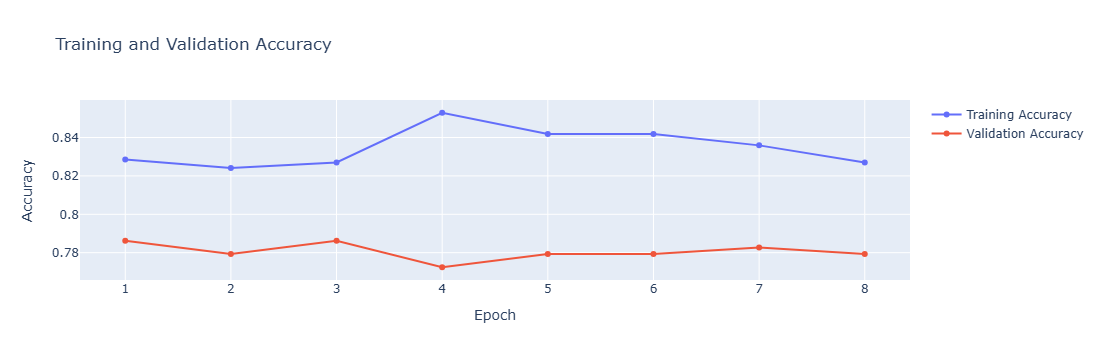

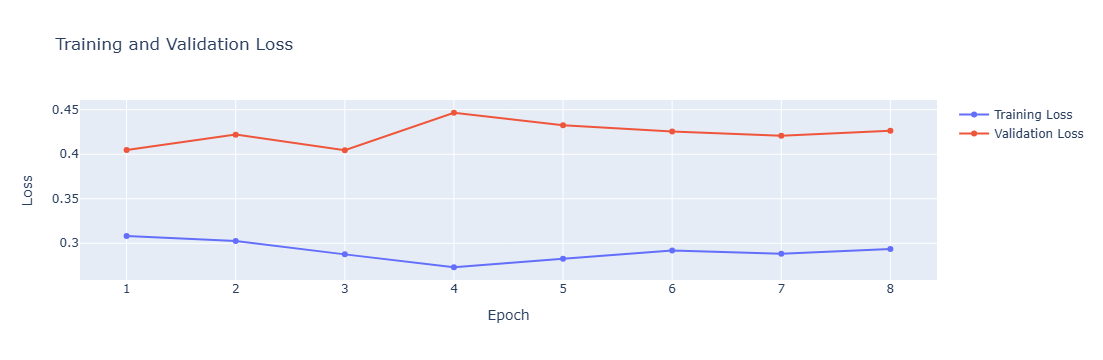

In [27]:
#Plot the graph
history_plot(epochs, history)

In [28]:
evaluate_model(model_IV3, test_generator)

Test Loss = 0.40005624294281006
Test Accuracy = 0.7827585935592651


In [29]:

# Get true labels and predicted probabilities
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predict class probabilities
y_pred_proba = model_IV3.predict(test_generator, verbose=1)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)

# 1️⃣ Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.30      0.49      0.37        76
Malignant cases       0.57      0.40      0.47       155
   Normal cases       0.19      0.19      0.19        59

       accuracy                           0.38       290
      macro avg       0.35      0.36      0.34       290
   weighted avg       0.42      0.38      0.39       290



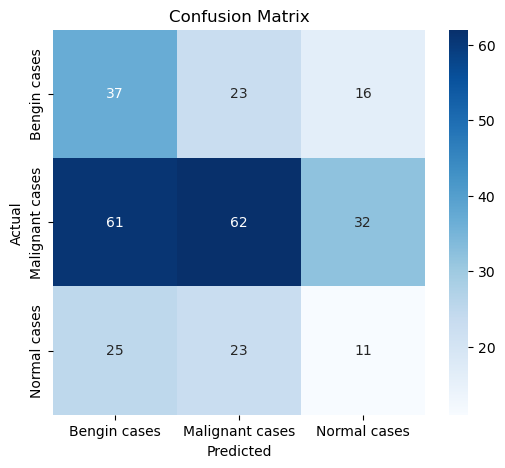

In [30]:
# 2️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Finetune VGG16 Model 

In [31]:
#Define base mode of VGG16
base_model_vgg16 = VGG16(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

#Freeze all layers VGG16 model
for layer in base_model_vgg16.layers:
    layer.trainable = False

#Add custom layers
model_VGG16 = Sequential()
model_VGG16 .add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model_VGG16 .add(base_model)
model_VGG16 .add(GlobalAveragePooling2D())
model_VGG16 .add(Dense(1024, activation = "relu"))
model_VGG16 .add(Dropout(0.4))
model_VGG16 .add(Dense(3, activation = "softmax"))

#Compile model
model_VGG16 .compile(optimizer = Adam(0.0002),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

#Training the model
epochs = 70
history = model_VGG16 .fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.6327 - loss: 0.7684 - val_accuracy: 0.6724 - val_loss: 0.6234 - learning_rate: 2.0000e-04
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.8027 - loss: 0.3904 - val_accuracy: 0.7655 - val_loss: 0.4434 - learning_rate: 2.0000e-04
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.7681 - loss: 0.3944 - val_accuracy: 0.8034 - val_loss: 0.3912 - learning_rate: 2.0000e-04
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.8156 - loss: 0.3436 - val_accuracy: 0.8621 - val_loss: 0.3204 - learning_rate: 2.0000e-04
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8111 - loss: 0.3345 - val_accuracy: 0.7724 - val_loss: 0.4450 - learning_rate: 2.0000e-04
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8302 - loss: 0.2995 - val_accuracy: 0.7414 - val_loss: 0.4636 - learning_rate: 2.0000e-04
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8232 

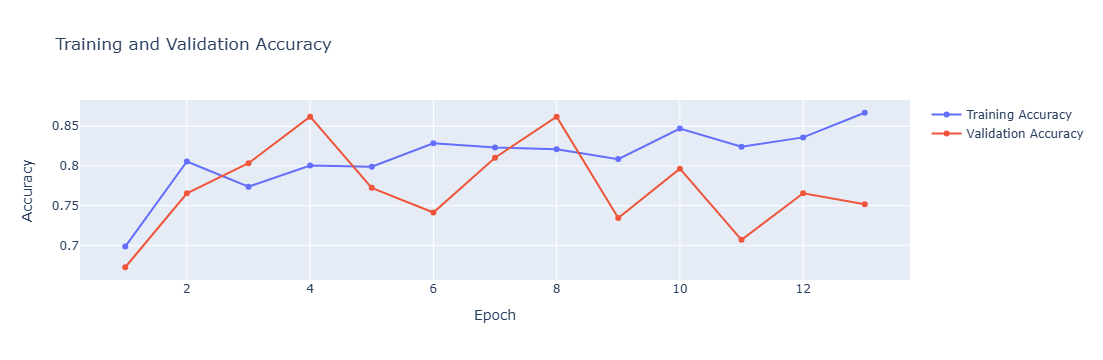

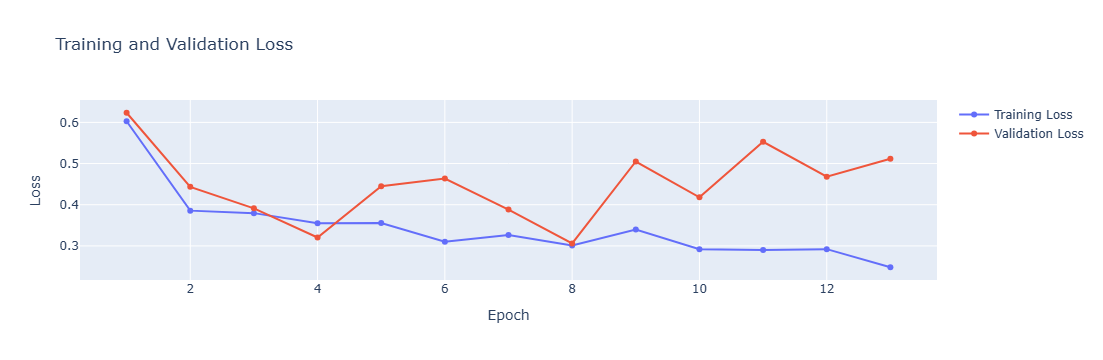

In [32]:
history_plot(epochs, history)

In [33]:
evaluate_model(model_VGG16 ,test_generator)

Test Loss = 0.3363041877746582
Test Accuracy = 0.8586207032203674


In [34]:
#Set the training layer jus block_conv1
base_model_vgg16.trainable = True
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#Compile the model
model_VGG16 .compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])   
#Training the model
epochs = 70
history = model_VGG16.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.8370 - loss: 0.2985 - val_accuracy: 0.8138 - val_loss: 0.3883 - learning_rate: 1.0000e-05
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.8612 - loss: 0.2747 - val_accuracy: 0.8241 - val_loss: 0.3645 - learning_rate: 1.0000e-05
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.8490 - loss: 0.2597 - val_accuracy: 0.8172 - val_loss: 0.3982 - learning_rate: 1.0000e-05
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.8317 - loss: 0.2773 - val_accuracy: 0.8276 - val_loss: 0.3668 - learning_rate: 1.0000e-05
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.8505 - loss: 0.2855 - val_accuracy: 0.8172 - val_loss: 0.3835 - learning_rate: 1.0000e-05
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.8428 - loss: 0.2705 - val_accuracy: 0.8414 - val_loss: 0.3424 - learning_rate: 1.0000e-05
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - accuracy: 0.8570 

In [35]:
history_plot(epochs,history)

In [36]:
evaluate_model(model_VGG16 ,test_generator)

Test Loss = 0.3601013123989105
Test Accuracy = 0.8413792848587036


In [37]:
# Get true labels and predicted probabilities
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predict class probabilities
y_pred_proba = model_VGG16.predict(test_generator, verbose=1)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)

# 1️⃣ Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step
Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.25      0.36      0.29        76
Malignant cases       0.57      0.45      0.50       155
   Normal cases       0.25      0.25      0.25        59

       accuracy                           0.39       290
      macro avg       0.36      0.35      0.35       290
   weighted avg       0.42      0.39      0.40       290



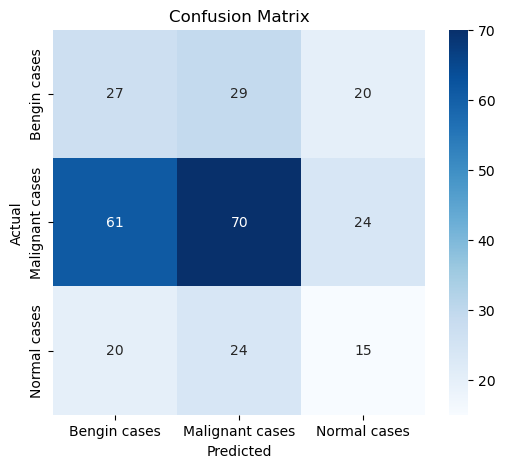

In [38]:
# 2️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show() 

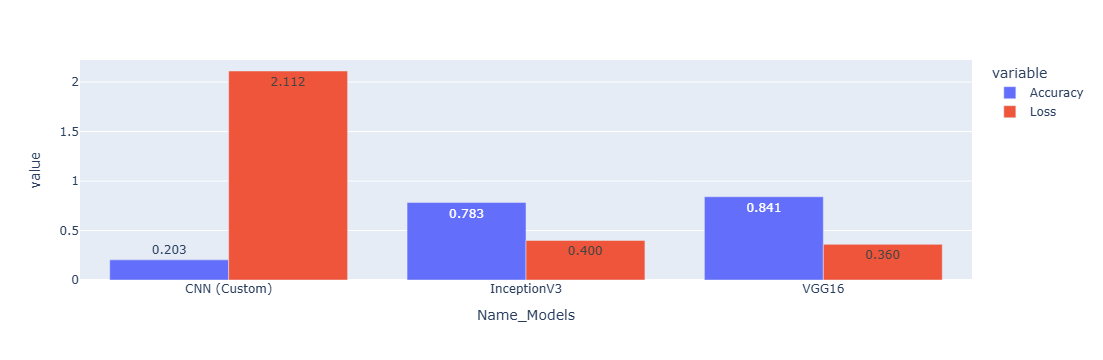

In [39]:
#Results of the model
models = [model_2D, model_IV3, model_VGG16 ]
loss = []
accuracy = []
for model in models:
    results = model.evaluate(test_generator, verbose = 0)
    loss.append(results[0])
    accuracy.append(results[1])

name_models = ["CNN (Custom)", "InceptionV3", "VGG16"]
df_loss_acc = pd.DataFrame(data = {"Name_Models" : name_models,
                                  "Loss" : loss,
                                  "Accuracy" : accuracy})

fig = px.bar(data_frame = df_loss_acc, x = "Name_Models", y = ["Accuracy", "Loss"],
            barmode = "group",
            text_auto = ".3f")
fig.show()